### MD Simulations and Calculations of Kinetic Properties 

### About the System

<img src="fig/npt-config.png" width="500" align="center"/>

### Compute the Einstein's Diffusion Constant in 3D (NVE)

$\overline{\Delta x^2(t)} = \sum_{t_0} (x(t_0 + t) - x(t_0))^2 / \sum_{t_0} 1 = 2*3Dt $ 

In [1]:
# Import dependencies
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import os

In [3]:
# Set the directory where the molecular dynamics trajectory files are stored
data_dir = './project1-md-trajectories'

# Initialize the MDAnalysis Universe with the topology (PDB file) and trajectory (TRR file) for methane
u = mda.Universe(f'{data_dir}/methane.pdb', f'{data_dir}/dt10fs/methane-nve.trr')

# Extract positions from each frame in the trajectory and store them in a numpy array
positions = np.array([frame.positions.copy() for frame in u.trajectory])

# Extract velocities from each frame in the trajectory and store in a numpy array
velosities = np.array([frame.velocities.copy() for frame in u.trajectory])

# Extract the dimensions of the simulation box at each frame and store in a numpy array
boxs = np.array([frame.dimensions.copy() for frame in u.trajectory])

# Print the total number of frames in the trajectory
print(f'Number of frames: {u.trajectory.n_frames}')

# Print the time step between frames in picoseconds
print(f'Time step: {round(u.trajectory.dt, 3)} ps')

Number of frames: 20001
Time step: 0.01 ps


In [4]:
# Position correction for periodic boundary conditions
# Calculate half the dimensions of the simulation box for boundary checking
half_box = boxs[0, :3] / 2

# Calculate differences between successive positions
differences = positions[1:] - positions[:-1]

# Determine where the boundaries are crossed
cross_lower_boundary = differences < -half_box 
cross_upper_boundary = differences > half_box

# Apply correction factors for the boundary crossings
position_correction = np.cumsum((cross_lower_boundary * boxs[1:, np.newaxis, :3]) - (cross_upper_boundary * boxs[1:, np.newaxis, :3]), axis=0)

# Correct the positions
positions[1:] += position_correction

# Check if all the positions are continuous (no jumps larger than half the box size)
continuous_positions = ((differences + position_correction) > -half_box).all() and ((differences + position_correction) < half_box).all()

In [5]:
# Create an array to store the average atomic weights for each atom in the simulation
aver_weight = np.array([{"C": 12.011, "H": 1.008}[atom.type] for atom in u.atoms])

# Retrieve the time step between frames in the simulation trajectory
dt = round(u.trajectory.dt, 3)

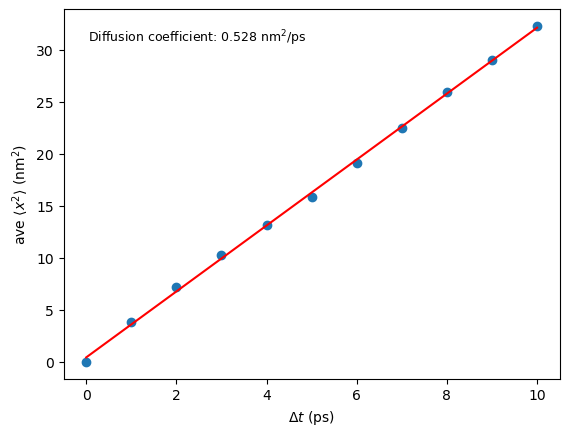

In [6]:
# Initialize a list to store the average of squared displacements
dx2_bars = []

# Define the starting time point for the calculation
t0 = 100

# Calculate the weighted average position of molecules for each frame
position_mol = np.average(positions, axis=1, weights=aver_weight)

# Define a time range to calculate displacements over
T = np.arange(11)

# Loop over each time interval in the range
for t in T:
    # Calculate displacement from the starting point (t0) to the current time (t + t0)
    dx_among_t0 = position_mol[round(t / dt):round((t0 + t) / dt)] - position_mol[:round(t0 / dt)]
    
    # Square the displacements and sum across all dimensions to get squared displacement
    dx2_mol_among_t0 = (dx_among_t0 ** 2).sum(axis=1)
    
    # Calculate the mean squared displacement for the current time interval
    dx2_t0_aver = dx2_mol_among_t0.mean()
    
    # Store the mean squared displacement in the list
    dx2_bars.append(dx2_t0_aver)

# Assuming T, dx2_bars are defined and populated with your data

# Plot the mean squared displacements against time intervals
plt.scatter(T, dx2_bars)

# Perform linear regression on the mean squared displacements to find the slope and intercept
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(T, dx2_bars)

# Calculate the diffusion coefficient from the slope of the linear fit, dividing by 6 due to the Einstein relation
D = slope / 6

# Plot the linear fit
plt.plot(T, T * slope + intercept, color='r')

# Label the x-axis and y-axis
plt.xlabel('$\Delta t$ (ps)')
plt.ylabel(r'ave $\langle x^2 \rangle$ (nm$^2$)')

# Add the diffusion coefficient text to the plot
plt.text(0.05, 0.95, f'Diffusion coefficient: {D:.3f} nm$^2$/ps', transform=plt.gca().transAxes, fontsize=9, verticalalignment='top')

plt.show()

### Compute Velocity Autocorrelation Function

$C_{vv}(t) = \sum_{t_0} v(t_0) \cdot v(t+t_0) / \sum_{t_0} 1$

$C_{vv}(t) = C_{vv}(0) \exp(-\gamma t)$

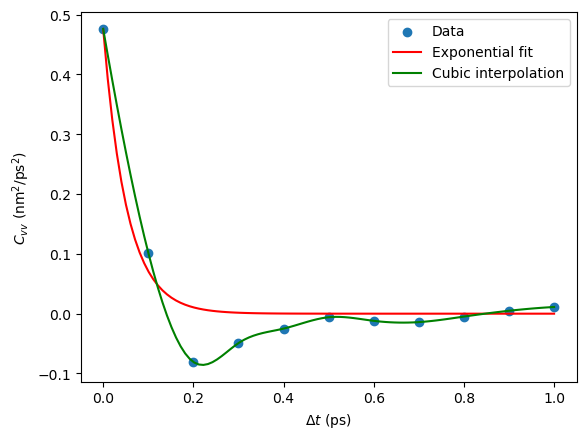

In [7]:
# Calculate the weighted average velocity of molecules for each frame
velosity_mol = np.average(velosities, axis=1, weights=aver_weight)

# Define the starting time point for correlation calculation
t0 = 100

# Initialize a list to store velocity autocorrelation values
Cvs = []

# Define a range of time intervals to compute correlations over
T = np.arange(11)/10

# Loop over each time interval
for t in T:
    # Calculate the dot product of velocities at the beginning and at time t, summing across all dimensions
    Cv_among_t0 = (velosity_mol[round(t / dt):round((t0 + t) / dt)] * velosity_mol[:round(t0 / dt)]).sum(axis=1)
    
    # Calculate the average velocity autocorrelation for the current time interval
    Cv_t0_aver = Cv_among_t0.mean() / 100
    
    # Store the average autocorrelation in the list
    Cvs.append(Cv_t0_aver)

# Plot the autocorrelation values against time intervals
plt.scatter(T, Cvs)

# Define a function for exponential fitting of the autocorrelation data
def func(x, gamma):
    return Cvs[0] * np.exp(-gamma * x)

# Fit the exponential function to the data to find the decay parameter
popt, pcov = scipy.optimize.curve_fit(func, T, Cvs)

# Generate a smooth range of time points for plotting the fit
X = np.linspace(T[0], T[-1], 100)

# Plot the exponential fit
plt.plot(X, func(X, *popt), color='r')

# Perform cubic interpolation of the autocorrelation data for a smoother curve
Cvs_interp = scipy.interpolate.interp1d(T, Cvs, kind='cubic')

# Plot the cubic interpolation
plt.plot(X, Cvs_interp(X), color='g')

# Calculate the correlation time by integrating the interpolated curve
gamma_coor = 1 / (scipy.integrate.quad(Cvs_interp, T[0], T[-1])[0] / Cvs[0])

# Label the axes
plt.xlabel('$\Delta t$ (ps)')
plt.ylabel(r'$C_{vv}$ (nm$^2$/ps$^2$)')

# Add a legend to the plot
plt.legend(["Data", 'Exponential fit', 'Cubic interpolation'])

# Display the plot
plt.show()

### Temperature in NVE

$\frac{C_0}{2m^2\gamma} = C_{vv}(0) = \frac{3kT}{m}$

In [13]:
# Calculate the temperature using the initial value of Cvs (Cvs[0])
tem = 16.048 * Cvs[0] * 1000 / 3 / 8.3145

# Print the calculated temperature with the label "Temperature:"
print("Temperature:", tem)

Temperature: 306.3454496898421


In [14]:
# Calculate diffusion coefficients using the Einstein relation, 
# with the values obtained from the exponential fit and cubic interpolation
D_1 = 8.3145 * tem / 16.048 / popt[0] * 0.1  # From exponential fit
D_2 = 8.3145 * tem / 16.048 / gamma_coor * 0.1  # From cubic interpolation

# Print the calculated diffusion coefficients
print(f'Diffusion coefficient from exponential fit: {D_1:.3f} nm^2/ps')
print(f'Diffusion coefficient from cubic interpolation: {D_2:.3f} nm^2/ps')

Diffusion coefficient from exponential fit: 0.835 nm^2/ps
Diffusion coefficient from cubic interpolation: 0.407 nm^2/ps
